# **ANN Intrusion Detection System**

The goal is to train a machine learning model using ANN, capable of determining whether the monitored network traffic is benign or malicious.

---

## **1- Importing Libraries**

In [2]:
import pandas
import glob
import seaborn
from matplotlib import pyplot
import re
import numpy
from sklearn.preprocessing import RobustScaler, LabelEncoder
from sklearn.model_selection import train_test_split
import tensorflow

## **2- Dataset**

### **Used Dataset: CICIDS2017**
- Intrusion Detection Evaluation Dataset.
- Contains benign and the most up-to-date attacks, which resemble real-world packet capture (PCAP) data.
- The data is housed in 8 different csv files, each containing varied attack data at different times.

### **Link to the dataset:**
https://www.kaggle.com/datasets/cicdataset/cicids2017/data

### **Preparing the Dataset**

In [48]:
# Collecting all csv files into a list.
path = "../MachineLearningCVE"
files = [file for file in glob.glob(path+"**/*.csv", recursive=True)]

for file in files:
    print(file)

..\MachineLearningCVE\Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv
..\MachineLearningCVE\Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv
..\MachineLearningCVE\Friday-WorkingHours-Morning.pcap_ISCX.csv
..\MachineLearningCVE\Monday-WorkingHours.pcap_ISCX.csv
..\MachineLearningCVE\Thursday-WorkingHours-Afternoon-Infilteration.pcap_ISCX.csv
..\MachineLearningCVE\Thursday-WorkingHours-Morning-WebAttacks.pcap_ISCX.csv
..\MachineLearningCVE\Tuesday-WorkingHours.pcap_ISCX.csv
..\MachineLearningCVE\Wednesday-workingHours.pcap_ISCX.csv


In [49]:
# Reading the data in all csv files and placing them in dataframes using Pandas.
dataset = [pandas.read_csv(file) for file in files]

# Printing the structure of the dataframes.
for df in dataset:
    print(df.shape)

(225745, 79)
(286467, 79)
(191033, 79)
(529918, 79)
(288602, 79)
(170366, 79)
(445909, 79)
(692703, 79)


From the output of the previous code block, all tables have the same number of columns. The next code block will check if all columns are the same.

In [50]:
# Checking if all columns from all the tables are the same.
for i in range(len(dataset)):
    if i != len(dataset)-1:
        flag = dataset[i].columns == dataset[i+1].columns\

        if flag.any() == False:    
            print(i)
            break    

Since all the columns are the same in all tables, it is now possible to combine all the dataframes into a single dataframe.

In [51]:
# Combining all tables into one dataset.
dataset = pandas.concat([df for df in dataset]).drop_duplicates(keep = False)
dataset.reset_index(drop = True, inplace = True)

# Checking the structure of the entire dataset
print(dataset.shape)

(2427193, 79)


## **3- Initial Data Analysis**

As shown below, the dataset contains approximately 2.5 million records, with 79 columns. The columns data types are mostly int64 and float64 with only 1 column being of the object type.

In [7]:
# Looking at the general information of the dataset.
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2427193 entries, 0 to 2427192
Data columns (total 79 columns):
 #   Column                        Dtype  
---  ------                        -----  
 0    Destination Port             int64  
 1    Flow Duration                int64  
 2    Total Fwd Packets            int64  
 3    Total Backward Packets       int64  
 4   Total Length of Fwd Packets   int64  
 5    Total Length of Bwd Packets  int64  
 6    Fwd Packet Length Max        int64  
 7    Fwd Packet Length Min        int64  
 8    Fwd Packet Length Mean       float64
 9    Fwd Packet Length Std        float64
 10  Bwd Packet Length Max         int64  
 11   Bwd Packet Length Min        int64  
 12   Bwd Packet Length Mean       float64
 13   Bwd Packet Length Std        float64
 14  Flow Bytes/s                  float64
 15   Flow Packets/s               float64
 16   Flow IAT Mean                float64
 17   Flow IAT Std                 float64
 18   Flow IAT Max         

The data contains 15 labels in total: 'BENIGN' which denotes normal traffic, and 14 malicious traffic (attack) types.

In [8]:
# Checking the labels (classes) of the dataset.
print(dataset[' Label'].unique(), "\n\nLength: " + str(len(dataset[' Label'].unique())))

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed'] 

Length: 15


In [9]:
# Preview of the content of the dataset.
dataset.head(10)

,Destination Port,Flow Duration,Total Fwd Packets,Total Backward Packets,Total Length of Fwd Packets,Total Length of Bwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,...,min_seg_size_forward,Active Mean,Active Std,Active Max,Active Min,Idle Mean,Idle Std,Idle Max,Idle Min,Label
0,54865,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
5,54871,1022,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
6,54925,4,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
7,54925,42,1,1,6,6,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
8,9282,4,2,0,12,0,6,6,6.0,0.00000,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
9,55153,4,2,0,37,0,31,6,18.5,17.67767,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


The following is a plot that shows the frequency of each attack in the dataset.

From the plot, it is evident that the most frequent attack types are DoS Hulk and DDoS respectively. This influences model selection greatly since the other types of attacks are much less than the previously mentioned types.

C:\Users\m639a\AppData\Local\Temp\ipykernel_1372\3368619907.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barChart = seaborn.countplot(info, palette='Set1')


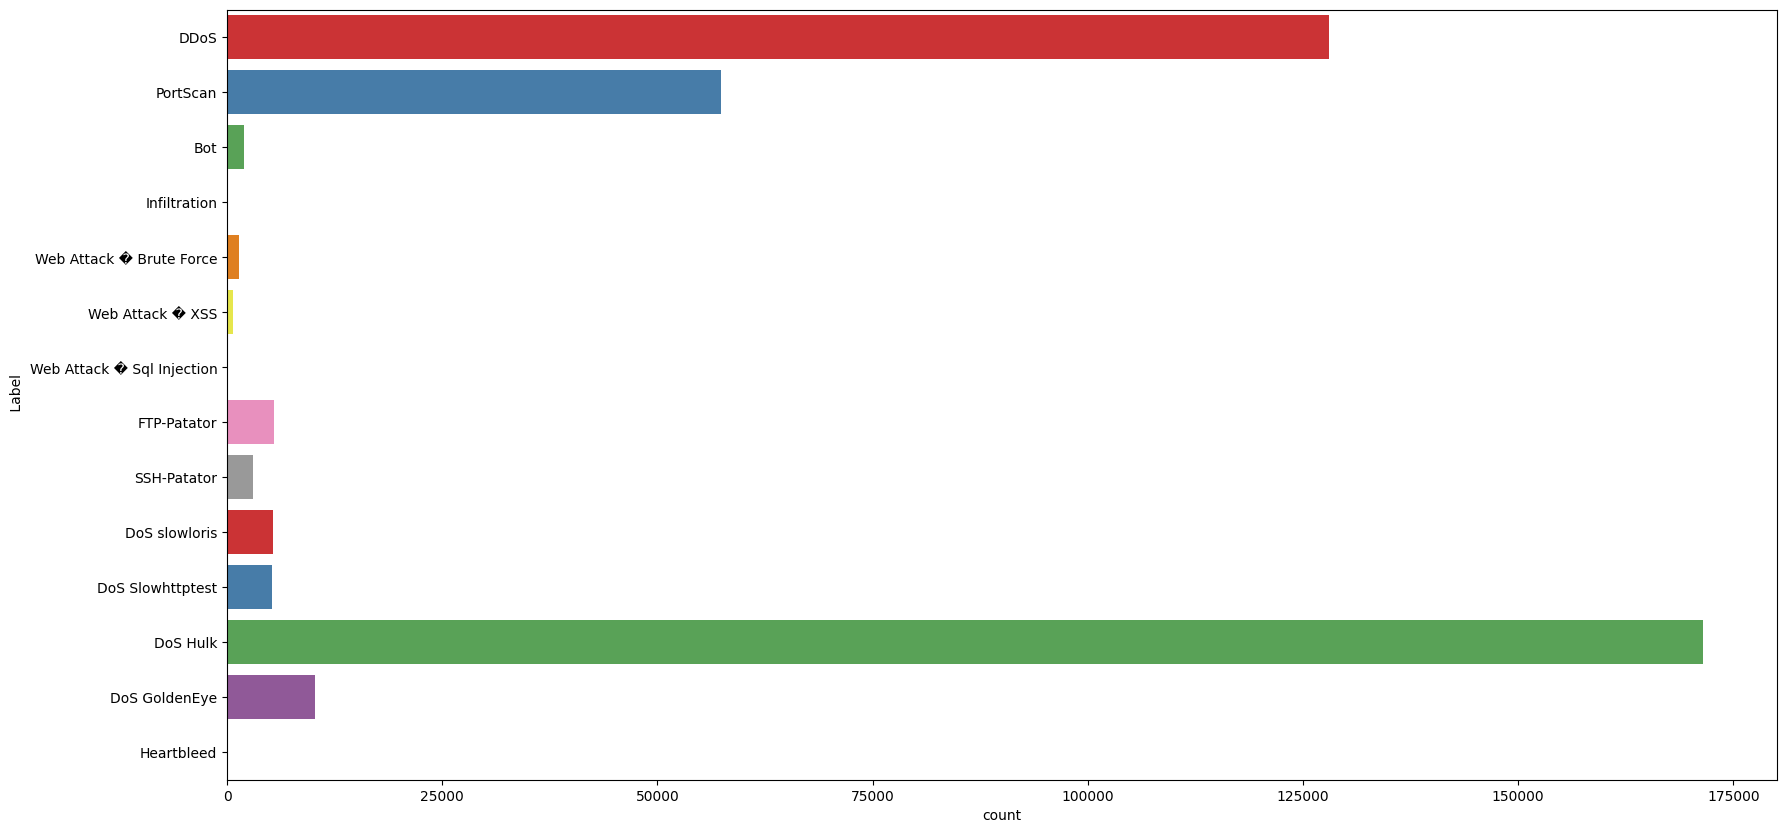

In [53]:
# Plotting the frequency of the different attack types.
info = dataset[' Label'].where(dataset[' Label'] != 'BENIGN')

pyplot.figure(figsize=(20,10))
barChart = seaborn.countplot(info, palette='Set1')

## **4- Data Preprocessing**

This section will include data cleaning and preparation, so that it becomes ready for training.

### **Data Cleaning Includes:**
- Renaming columns
- Removing NaN (null) values
- Removing non-finite values

**Renaming Columns**

In [11]:
# Renaming columns by removing whitespaces.

colNames = [col.replace(' ', '') for col in dataset.columns]
dataset.columns = colNames
dataset.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
1,55054,109,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
2,55055,52,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
3,46236,34,1,1,6,6,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN
4,54863,3,2,0,12,0,6,6,6.0,0.0,...,20,0.0,0.0,0,0,0.0,0.0,0,0,BENIGN


Label column values contain some unknown characters. These characters will be removed.

In [12]:
# Label values before removal of the unknown characters.
print(dataset['Label'].unique())

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration'
 'Web Attack � Brute Force' 'Web Attack � XSS'
 'Web Attack � Sql Injection' 'FTP-Patator' 'SSH-Patator' 'DoS slowloris'
 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye' 'Heartbleed']


In [13]:
# Removing the unknown characters in the Label values using regular exepression.
labels = dataset['Label'].unique()
labels = [re.sub("[^a-zA-Z]+", " ", str(name)) for name in labels]

# Overwriting Label values in the dataset.
tempLabels = dataset['Label'].unique()
for i in range(len(tempLabels)):
    dataset['Label'] = dataset['Label'].replace({tempLabels[i] : labels[i]})

print(dataset['Label'].unique())

['BENIGN' 'DDoS' 'PortScan' 'Bot' 'Infiltration' 'Web Attack Brute Force'
 'Web Attack XSS' 'Web Attack Sql Injection' 'FTP Patator' 'SSH Patator'
 'DoS slowloris' 'DoS Slowhttptest' 'DoS Hulk' 'DoS GoldenEye'
 'Heartbleed']


**Removing NaN (null) Values**

In [14]:
# Checking if the dataset contains any null values.
print(dataset.isnull().values.any())

True


In [15]:
# Checking which columns contain null values.
print([col for col in dataset if dataset[col].isnull().values.any()])

['FlowBytes/s']


In [16]:
# Finding out how many rows are affected and how much do the make of the entire dataset.
sum = dataset['FlowBytes/s'].isnull().sum()
print(sum)
print(sum/dataset.shape[0]*100)

334
0.013760751617197316


Since the sum of rows that have null values is only about 0.014%, which does not contribute much to the dataset, it is safe to remove them as they will not affect model training.

In [17]:
# Removing the affected rows.
dataset.dropna(inplace = True)

# Checking if all null values are dropped.
print(dataset.isnull().values.any())

False


**Removing Non-finite Values**

In [18]:
# Checking if all values in the dataset are finite.
labels = dataset['Label']
dataset = dataset.iloc[:, dataset.columns != 'Label'].astype('float64')
numpy.all(numpy.isfinite(dataset))

False

In [19]:
# Checking which columns contain non-finite values.
nf = [column for column in dataset if not numpy.all(numpy.isfinite(dataset[column]))]

print(nf)

['FlowBytes/s', 'FlowPackets/s']


In [20]:
# Checking how many rows are contain non-finite values.
finiteBytes = numpy.isfinite(dataset['FlowBytes/s']).sum()
print("From FlowBytes: " + str(dataset.shape[0] - finiteBytes))

finitePackets = numpy.isfinite(dataset['FlowPackets/s']).sum()
print("From FlowPackets: " + str(dataset.shape[0] - finitePackets))

From FlowBytes: 1132
From FlowPackets: 1132


Since the number of records containing non-finite values is not large relative to the entirety of the dataset. This makes it safe to remove these records.

In [21]:
# Replacing the records containing non-finite values with NaN values.
dataset = dataset.replace([numpy.inf, -numpy.inf], numpy.nan)

# Checking if the dataset contains NaN again.
print(numpy.any(numpy.isnan(dataset)))

True


In [22]:
# Adding the labels back to the dataset.
dataset = dataset.merge(labels, how = 'outer', left_index = True, right_index = True)

# Removing the previously added NaN values.
dataset.dropna(inplace = True)

In [23]:
print(dataset.shape)
dataset.head()

(2425727, 79)


,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin,Label
0,54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
1,55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
2,55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
3,46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN
4,54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BENIGN


In [24]:
# Saving the cleaned dataset. This requires about 1.05GB of storage.
dataset.to_csv("../Cleaned_Dataset.csv", index = False)

### **Data Preparation Includes:**
- Data Scaling
- Label Encoding
- Data Splitting

**Data Scaling**

To scale the data, RobustScaler from sklearn will be used. The choice behind using RobustScaler is because it makes sure that outliers in the dataset will be preserved.

In [25]:
# Dividing the dataset into labels and features.
labels = dataset['Label']
features = dataset.iloc[:, dataset.columns != 'Label'].astype('float64')

features.head()

,DestinationPort,FlowDuration,TotalFwdPackets,TotalBackwardPackets,TotalLengthofFwdPackets,TotalLengthofBwdPackets,FwdPacketLengthMax,FwdPacketLengthMin,FwdPacketLengthMean,FwdPacketLengthStd,...,act_data_pkt_fwd,min_seg_size_forward,ActiveMean,ActiveStd,ActiveMax,ActiveMin,IdleMean,IdleStd,IdleMax,IdleMin
0,54865.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,55054.0,109.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,55055.0,52.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,46236.0,34.0,1.0,1.0,6.0,6.0,6.0,6.0,6.0,0.0,...,0.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,54863.0,3.0,2.0,0.0,12.0,0.0,6.0,6.0,6.0,0.0,...,1.0,20.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
# Scaling using RobustScaler.
scaler = RobustScaler()
scaler.fit(features)
features = scaler.transform(features)

# Checking if successful.
features

array([[ 1.40474359e+02, -1.08800488e-02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.40958974e+02, -1.08609909e-02, -2.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [ 1.40961538e+02, -1.08712390e-02, -2.50000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       ...,
       [ 1.48589744e+02, -1.08658453e-02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.92307692e-02,  1.77654485e-01,  1.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
       [-6.92307692e-02,  6.18858398e-03,  5.00000000e-01, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

**Label Encoding**

Since the dataset contains 15 labels, it will be required to convert them into numerical values. This will be done using LabelEncoder from sklearn.

In [27]:
# Loading the cleaned dataset.
dataset = pandas.read_csv("../Cleaned_Dataset.csv", index_col = [0])

In [28]:
# Converting the labels (classes) from the dataset into numerical values.
labelEncoder = LabelEncoder()
labelEncoder.fit(labels)
labels = labelEncoder.transform(labels)

# Checking the encoded labels.
numpy.unique(labels)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14])

In [29]:
# Checking that reversing the encoding works.
decodedLabels = labelEncoder.inverse_transform(labels)
pandas.Series(decodedLabels)
numpy.unique(decodedLabels)

array(['BENIGN', 'Bot', 'DDoS', 'DoS GoldenEye', 'DoS Hulk',
       'DoS Slowhttptest', 'DoS slowloris', 'FTP Patator', 'Heartbleed',
       'Infiltration', 'PortScan', 'SSH Patator',
       'Web Attack Brute Force', 'Web Attack Sql Injection',
       'Web Attack XSS'], dtype=object)

**Data Splitting**

In this section, the train_test_split function from sklearn will be used to split the dataset into training and test sets. Using this will function will provide similar data variance in both sets.

In [30]:
# Splitting the dataset into training and test sets (80:20 split, training:test)
features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size = 0.2)

# Checking the structure of each.
print("features: " + str(features_train.shape) + " " + str(features_test.shape))
print("labels: " + str(labels_train.shape) + " " + str(labels_test.shape))

features: (1940581, 78) (485146, 78)
labels: (1940581,) (485146,)


## **5- Modeling**

This section includes building the ANN model. It will be a multi-layer feedforward neural network, with backpropagation that will be capable of classifying multiple classes (14 attack type class and a normal traffic class).

The steps included are:
- Building the ANN model
- Training the model on the obtained training set
- Evaluating the model using the obtained test set

**ANN Model Building**

This will take place by utilizing the Sequential model from tensorflow. This model has 3 layers: input, hidden, and output.

- The input layer contains 78 neurons, which are the number of features in the dataset.
- The hidden layer contains 35 neurons. This number was calculated using the Geometric Mean rule: (input neurons * output neurons)^0.5 - The value was rounded up.
- The output layer contains 15 neurons, which are the labels (classes) present in the dataset.

The activation functions that will be used are the standard ones for multi-class classification. ReLu will be used for the hidden layer and softmax will be used for the output layer.

To decrease the chance of overfitting, a dropout parameter will be used to randomly drop a percentage of the neurons during each learning iteration. The dropout parameter in this case will be 0.2, which will drop 20% of said neurons.

In [ ]:
annModel = tensorflow.keras.models.Sequential([
    tensorflow.keras.layers.Flatten(input_shape = (78,)),
    tensorflow.keras.layers.Dense(35, activation = 'relu'),
    tensorflow.keras.layers.Dropout(0.2),
    tensorflow.keras.layers.Dense(15, activation = 'softmax')
])

To optimize the learning rate, adam optimizer will be used, and the loss function will be sparse categorical crossentropy, which the standard loss function for multi-class classification.

In [ ]:
annModel.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

**ANN Model Training**

In [ ]:
history = annModel.fit(features_train, labels_train, epochs = 10)

**ANN Model Evaluation**

In [34]:
print(history.history.keys())

dict_keys(['loss', 'accuracy'])


In [39]:
# Evaluating the accuracy of the model.
modelScore = annModel.evaluate(features_test, labels_test)
print("Loss: ", modelScore[0])
print("Accuracy: ", modelScore[1])

15161/15161 [==============================] - 21s 1ms/step - loss: 0.2791 - accuracy: 0.9106
Loss:  0.2790587842464447
Accuracy:  0.9106433987617493


As seen above, the model is able to predict attacks with an accuracy of 91%.

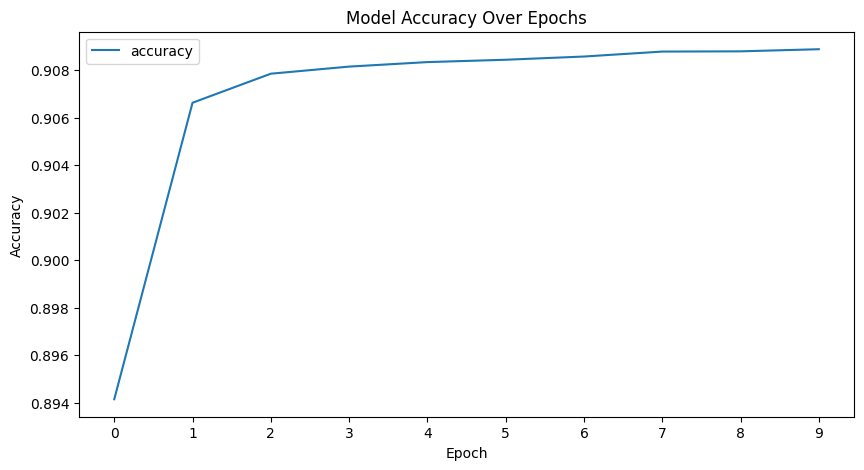

In [41]:
# Plotting a summary for the history of accuracy.
pyplot.figure(figsize = (10,5))
pyplot.plot(history.history['accuracy'])
pyplot.title('Model Accuracy Over Epochs')
pyplot.xlabel('Epoch')
pyplot.xticks(range(0, len(history.history['accuracy']), len(history.history['accuracy']) // 10))
pyplot.ylabel('Accuracy')
pyplot.legend(['accuracy', 'tets'])

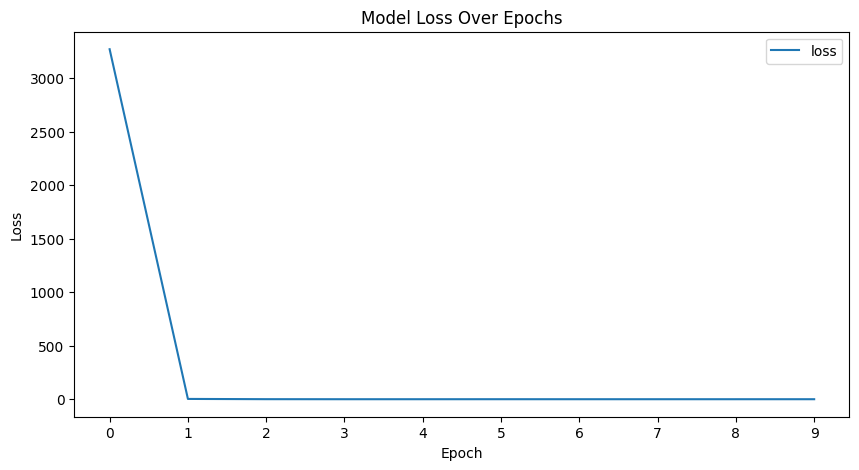

In [42]:
# Plotting a summary for the history of loss.
pyplot.figure(figsize = (10,5))
pyplot.plot(history.history['loss'])
pyplot.title('Model Loss Over Epochs')
pyplot.xlabel('Epoch')
pyplot.xticks(range(0, len(history.history['loss']), len(history.history['loss']) // 10))
pyplot.ylabel('Loss')
pyplot.legend(['loss', 'tets'])

In [43]:
# Assuming annModel is your trained neural network model
# features_test is your test set features

# Make predictions on the test set
predicted_probabilities = annModel.predict(features_test)

# Convert predicted probabilities to predicted labels
predicted_labels = numpy.argmax(predicted_probabilities, axis=1)

# Now 'predicted_labels' contains the predicted class labels for your test set
print(predicted_labels)

15161/15161 [==============================] - 17s 1ms/step
[0 0 0 ... 0 0 0]


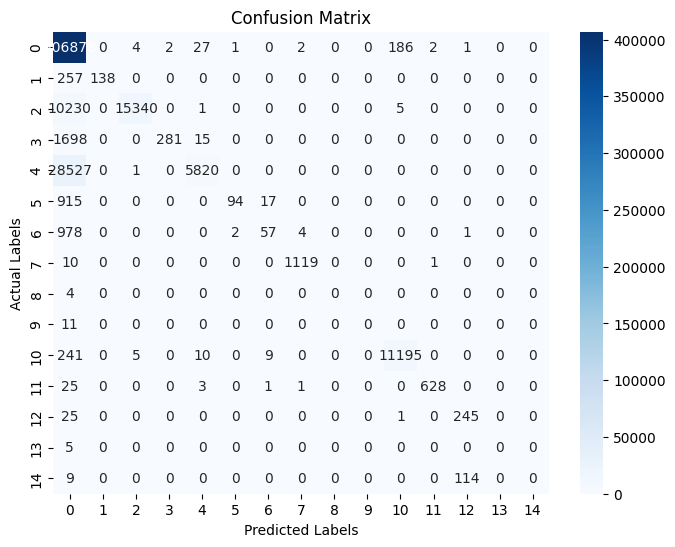

In [46]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(labels_test, predicted_labels)
pyplot.figure(figsize=(8, 6))
seaborn.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=numpy.unique(labels_test), yticklabels=numpy.unique(labels_test))
pyplot.title('Confusion Matrix')
pyplot.xlabel('Predicted Labels')
pyplot.ylabel('Actual Labels')
pyplot.show()